In [1]:
!pip install google-play-scraper
!pip install snscrape

from google_play_scraper import app, reviews, Sort, reviews_all

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score


import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Preprocessing

In [2]:
import pandas as pd


df = pd.read_csv('ulasan_aplikasi.csv')

print(df.columns)


Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')


In [3]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

df = pd.read_csv('ulasan_aplikasi.csv')
df = df[['content']].dropna()


def cleaningText(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['text_clean'] = df['content'].apply(cleaningText)


slangwords = {
    "gk": "tidak", "ga": "tidak", "nggak": "tidak", "tdk": "tidak",
    "bgt": "banget", "dr": "dari", "dgn": "dengan", "tp": "tapi",
    "udh": "sudah", "blm": "belum", "trs": "terus", "jg": "juga"
}

def fix_slangwords(text):
    return ' '.join([slangwords.get(word, word) for word in text.split()])

df['text_slang'] = df['text_clean'].apply(fix_slangwords)


def tokenizingText(text):
    return text.split()

df['text_tokens'] = df['text_slang'].apply(tokenizingText)


stop_words = set(stopwords.words('indonesian'))

def filteringText(words):
    return [word for word in words if word not in stop_words]

df['text_stopwords'] = df['text_tokens'].apply(filteringText)


def toSentence(words):
    return ' '.join(words)

df['text_final'] = df['text_stopwords'].apply(toSentence)


print(df[['content', 'text_final']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                             content  \
0  film²nya dan seriesnya banyak dan populer² ser...   
1  kata temen saya ini aplikasi lengkap!! tapi me...   
2  saat menonton video selalu terjadi kesalahan d...   
3  semakin susah masuk akun, katanya bukan akun r...   
4  tiap mau nonton pasti ada kesalahan vidio coba...   

                                          text_final  
0  film nya seriesnya populer bagus jarang error ...  
1  temen aplikasi lengkap lengkap film cartoon yg...  
2  menonton video kesalahan video putar mencoba p...  
3  susah masuk akun akun rumah netflix logout per...  
4  nonton kesalahan vidio coba sampe restart apli...  


### Stemming

In [4]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmingText(text):
    return stemmer.stem(text)


df['text_stemmed'] = df['text_final'].apply(stemmingText)


print(df[['content', 'text_final', 'text_stemmed']].head())


                                             content  \
0  film²nya dan seriesnya banyak dan populer² ser...   
1  kata temen saya ini aplikasi lengkap!! tapi me...   
2  saat menonton video selalu terjadi kesalahan d...   
3  semakin susah masuk akun, katanya bukan akun r...   
4  tiap mau nonton pasti ada kesalahan vidio coba...   

                                          text_final  \
0  film nya seriesnya populer bagus jarang error ...   
1  temen aplikasi lengkap lengkap film cartoon yg...   
2  menonton video kesalahan video putar mencoba p...   
3  susah masuk akun akun rumah netflix logout per...   
4  nonton kesalahan vidio coba sampe restart apli...   

                                        text_stemmed  
0  film nya seriesnya populer bagus jarang error ...  
1  temen aplikasi lengkap lengkap film cartoon yg...  
2  tonton video salah video putar coba baik kali ...  
3  susah masuk akun akun rumah netflix logout per...  
4  nonton salah vidio coba sampe restart aplikasi..

In [5]:

positive_words = {
    'bagus', 'baik', 'mantap', 'suka', 'cepat', 'puas', 'lancar', 'mudah',
    'keren', 'mantul', 'top', 'rekomendasi', 'senang', 'cocok', 'berhasil'
}
negative_words = {
    'buruk', 'jelek', 'lama', 'error', 'parah', 'lemot', 'kecewa', 'susah',
    'gagal', 'crash', 'keluar', 'hang', 'payah', 'benci', 'ribet'
}

# Fungsi analisis sentimen
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text.split():
        if word in positive_words:
            score += 1
        elif word in negative_words:
            score -= 1
    if score > 0:
        label = 'positif'
    elif score < 0:
        label = 'negatif'
    else:
        label = 'netral'
    return score, label


In [6]:
results = df['text_final'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))  #
df['polarity_score'] = results[0]
df['polarity'] = results[1]


In [7]:
print(df[['content', 'text_stemmed', 'polarity_score', 'polarity']].head(10))


                                             content  \
0  film²nya dan seriesnya banyak dan populer² ser...   
1  kata temen saya ini aplikasi lengkap!! tapi me...   
2  saat menonton video selalu terjadi kesalahan d...   
3  semakin susah masuk akun, katanya bukan akun r...   
4  tiap mau nonton pasti ada kesalahan vidio coba...   
5  Enek banget sm netflix sekarang, gk ky dulu. S...   
6  udah beberapa bulan yang lalu, masuk doang gab...   
7  Udah ok. Tapi seringkali ketika mau lanjut men...   
8  Aplikasi buruk tidak sesuai dengan langganan f...   
9  Kenapa sih mau masuk doang bikin emosi , padah...   

                                        text_stemmed  polarity_score polarity  
0  film nya seriesnya populer bagus jarang error ...               0   netral  
1  temen aplikasi lengkap lengkap film cartoon yg...               0   netral  
2  tonton video salah video putar coba baik kali ...               0   netral  
3  susah masuk akun akun rumah netflix logout per...           

### Splitting Data

In [8]:
X = df['text_stemmed']
y = df['polarity']


In [9]:
from sklearn.model_selection import train_test_split

# 80/20
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

 #70/30
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

#  60/40
X_train_60, X_test_40, y_train_60, y_test_40 = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y)


In [10]:
print("Distribusi label skema 80/20:\n", y_train_80.value_counts(normalize=True))
print("\nDistribusi label skema 70/30:\n", y_train_70.value_counts(normalize=True))
print("\nDistribusi label skema 60/40:\n", y_train_60.value_counts(normalize=True))


Distribusi label skema 80/20:
 polarity
netral     0.659833
negatif    0.173056
positif    0.167111
Name: proportion, dtype: float64

Distribusi label skema 70/30:
 polarity
netral     0.659810
negatif    0.173079
positif    0.167111
Name: proportion, dtype: float64

Distribusi label skema 60/40:
 polarity
netral     0.659852
negatif    0.173037
positif    0.167111
Name: proportion, dtype: float64


In [11]:
data_splits = {
    '80_20': (X_train_80, X_test_20, y_train_80, y_test_20),
    '70_30': (X_train_70, X_test_30, y_train_70, y_test_30),
    '60_40': (X_train_60, X_test_40, y_train_60, y_test_40)
}


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


def train_and_evaluate(model, split_key, model_name='Model'):
    X_train, X_test, y_train, y_test = data_splits[split_key]

    # Pipeline TF-IDF + Model
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
        ('clf', model)
    ])

    # Train
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)


    print(f"\n=== Evaluasi untuk {model_name} ({split_key}) ===")
    print(classification_report(y_test, y_pred))
    print(f"Akurasi: {accuracy_score(y_test, y_pred):.4f}")


    cm = confusion_matrix(y_test, y_pred, labels=['positif', 'netral', 'negatif'])
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['positif', 'netral', 'negatif'], yticklabels=['positif', 'netral', 'negatif'], cmap='Blues')
    plt.title(f'Confusion Matrix {model_name} ({split_key})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return pipeline


In [13]:
# Skema 1: TF-IDF + SVM (80/20)
svm_model_80 = train_and_evaluate(SVC(kernel='linear'), '80_20', 'SVM')

# Skema 2: TF-IDF + RF (70/30)
rf_model_70 = train_and_evaluate(RandomForestClassifier(n_estimators=100), '70_30', 'Random Forest')

# Skema 3: TF-IDF + SVM (60/40)
svm_model_60 = train_and_evaluate(SVC(kernel='linear'), '60_40', 'SVM 60/40')



=== Evaluasi untuk SVM (80_20) ===
              precision    recall  f1-score   support

     negatif       0.94      0.96      0.95       779
      netral       0.97      0.97      0.97      2969
     positif       0.95      0.91      0.93       752

    accuracy                           0.96      4500
   macro avg       0.95      0.95      0.95      4500
weighted avg       0.96      0.96      0.96      4500

Akurasi: 0.9604



=== Evaluasi untuk Random Forest (70_30) ===
              precision    recall  f1-score   support

     negatif       0.91      0.98      0.94      1168
      netral       0.98      0.96      0.97      4454
     positif       0.92      0.93      0.93      1128

    accuracy                           0.96      6750
   macro avg       0.94      0.96      0.95      6750
weighted avg       0.96      0.96      0.96      6750

Akurasi: 0.9563



=== Evaluasi untuk SVM 60/40 (60_40) ===
              precision    recall  f1-score   support

     negatif       0.92      0.96      0.94      1558
      netral       0.97      0.97      0.97      5938
     positif       0.95      0.91      0.93      1504

    accuracy                           0.96      9000
   macro avg       0.95      0.94      0.94      9000
weighted avg       0.96      0.96      0.96      9000

Akurasi: 0.9554


# Interference


=== Evaluasi untuk SVM (80_20) ===
              precision    recall  f1-score   support

     negatif       0.93      0.91      0.92       779
      netral       0.95      0.97      0.96      2969
     positif       0.95      0.87      0.91       752

    accuracy                           0.94      4500
   macro avg       0.94      0.92      0.93      4500
weighted avg       0.94      0.94      0.94      4500

Akurasi: 0.9431


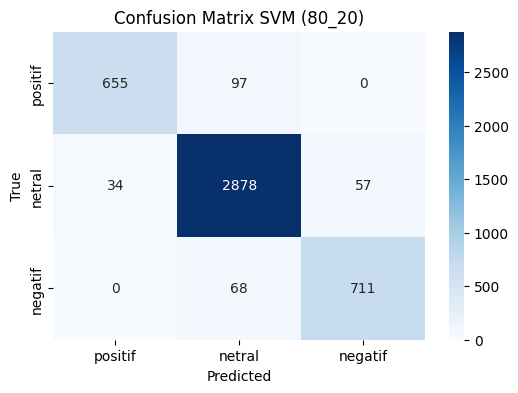

Prediksi: ['positif']


In [14]:

pipeline = train_and_evaluate(SVC(), '80_20', 'SVM')

# Sample untuk prediksi
sample = ["aplikasinya bagus banget dan bermanfaat"]

prediction = pipeline.predict(sample)


print("Prediksi:", prediction)


###   Deep Learning Model

In [15]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score


le = LabelEncoder()
y = le.fit_transform(df['polarity'])
num_classes = len(le.classes_)


tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text_stemmed'])

sequences = tokenizer.texts_to_sequences(df['text_stemmed'])
padded_sequences = pad_sequences(sequences, padding='post', maxlen=100)


y_cat = to_categorical(y)


from sklearn.model_selection import train_test_split

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    padded_sequences, y_cat, test_size=0.2, random_state=42, stratify=y
)


In [16]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train_dl, y_train_dl,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_dl, y_test_dl)
)



Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - accuracy: 0.6510 - loss: 0.9091 - val_accuracy: 0.6598 - val_loss: 0.8779
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - accuracy: 0.6623 - loss: 0.8786 - val_accuracy: 0.6598 - val_loss: 0.8773
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 136ms/step - accuracy: 0.6594 - loss: 0.8827 - val_accuracy: 0.6598 - val_loss: 0.8772
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 39s 131ms/step - accuracy: 0.6580 - loss: 0.8812 - val_accuracy: 0.6598 - val_loss: 0.8770
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.6638 - loss: 0.8742 - val_accuracy: 0.6598 - val_loss: 0.8780
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.6624 - loss: 0.8752 - val_accuracy: 0.6598 - val_loss: 0.8776
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - accuracy: 0.6650 - loss: 0.8707 - val_accuracy: 0.6598 - val_loss: 0.8781
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 39s 131ms/step - accuracy: 0.6597 - loss: 0.8785 - val

In [17]:

y_pred_dl = model.predict(X_test_dl)
y_pred_labels = y_pred_dl.argmax(axis=1)
y_true_labels = y_test_dl.argmax(axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))
print("Akurasi:", accuracy_score(y_true_labels, y_pred_labels))


141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00       779
      netral       0.66      1.00      0.80      2969
     positif       0.00      0.00      0.00       752

    accuracy                           0.66      4500
   macro avg       0.22      0.33      0.27      4500
weighted avg       0.44      0.66      0.52      4500

Akurasi: 0.6597777777777778


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
